In [2]:
import sys  
sys.path.insert(0, '../Libraries/') 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Weather data
* Source: https://www.visualcrossing.com/ Fee for uploading more than 100 lines of info. Please contact me with your needs, I will happily pay for your data
* Units: Wind is km/h, Temperature Celsius, Solar Radiation W/m^2


In [4]:
url = "https://github.com/yvesdubief/UVM-ME144-Heat-Transfer/blob/master/Snow-Cooling/Climate/EssexJct-05012020-10312020.xlsx"
weather = pd.read_excel('Climate/EssexJct-05012020-10312020.xlsx',header=0,date_parser=[5],)

In [5]:
weather.columns

Index(['Name', 'Wind Direction', 'Latitude', 'Cloud Cover',
       'Minimum Temperature', 'Date time', 'Precipitation', 'Solar Radiation',
       'Dew Point', 'Relative Humidity', 'ID', 'Precipitation Cover',
       'Longitude', 'Info', 'Temperature', 'Maximum Temperature', 'Visibility',
       'Wind Speed', 'Solar Energy', 'Heat Index', 'Weather Type',
       'Snow Depth', 'Sea Level Pressure', 'Snow', 'Name.1', 'Wind Gust',
       'Conditions', 'Wind Chill'],
      dtype='object')

In [6]:
weather = weather.set_index('Date time')

In [7]:
weather['Solar Radiation'] = weather['Solar Radiation'].fillna(0.0)

# The slab problem

A slab made of insulation foam panels with thermal conductivity $k = 0.022 \mathrm{W}/\mathrm{m}.\mathrm{K}$ (https://www.poliuretano.it/EN/thermal_conductivity_polyurethane.html), thickness $5\mathrm{cm}$ and  dimensions $10\times10\mathrm{m}^2$ is subjected to the weather of Essex Junction, VT. The bottom surface temperature is maintained at a constant temperature $T_{s,lower}$. **Compute the weekly, monthly and total heat rate necessary to maintain** $T_{s,lower}=0^\circ\mathrm{C}$ 

### Assumptions:
* The heat transfer from rain is not considered
* The position of the sun is not considered (The plate receives the full solar irradiation)
* The direction of the wind is always assumed to be perpendicular to one of the edges of the plate
* The time scale of the fluctuations of wall heat flux from convection and radiation are long enough that the temperature profile can be approximated as linear at all times
* The upper surface temperature is assumed to be spatially uniform

### Equations

The heat rate necessary to keep the lower surface at $0^\circ\mathrm{C}$ is
$$
q''_{cond}=\frac{k}{H}\left(T_{s,upper}-T_{s,lower}\right)
$$

To determine $T_{s,upper}$, the conservation of energy is applied to the upper surface:
$$
\rho C_p \frac{dT_{s,upper}}{dt}AH = g(T_{s,upper},t)=\sum q_{in}-\sum q_{out}
$$
or using $T=T_{s,upper}$
$$
\frac{dT}{dt} = f(T,t)=\frac{1}{\rho C_pAH}\sum q_{in}-\sum q_{out}
$$
For now we consider only the effect from convection and solar irradiation, assuming that the irradiation reported in the data is absorbed by the surface with an absorptivity $\alpha_s$.

$$
\sum q_{in}= hA(T_\infty - T_{s,upper})
$$
$$
\sum q_{out}=\frac{kA}{H}(T_{s,upper} - T_{s,lower})
$$
Note that when $T_\infty$ is lower than $T_{s,upper}$, the $\sum q_{in}$ is negative which is the correct physical process. The convection coefficient is to be determined with the appropiate correlation. 

For the initial condition, $t=0$, $T_{s,upper}$ is assumed to be at ambient temperature. The solution of the conservation of energy is updated numerically. 

The simplest, but least accurate method, is the Euler method, where
$$
\frac{dT}{dt} = \frac{T(t+\Delta t)-T(t)}{\Delta t}
$$
or

$$
T(t+\Delta t)=T(t)+(\Delta t)f(T,t)
$$

This method's error is first order, i.e. the leading term in the truncation error term is affected by $\Delta t$. It is also an unstable time integration method unless $\Delta t$ is very small. To increase accuracy and stability we propose to use the second order predictor-corrector method, which is a two step process. The first step is to estimate $T$ and $t+\Delta t$ using the information available at $t$
* **Predictor step**

$$
T^*=T(t)+(\Delta t)f(T,t)
$$

The second is to correct this estimate by taking the average of the RHS, $f$, of our ODE between the predictor step and the RHS at $f(T^*,t+\Delta t)$

* **Corrector step**

$$
T(t+\Delta t)=T(t)+\frac{(\Delta t)}{2}\left[f(T,t)+f(T^*,t+\Delta t)\right]
$$
This method is second order accurate in time.

### The stability problem

Even with the predictor corrector, the time step of integration cannot be too large. The $15\mathrm{min}$ increment of the data is too long and leads to `NaN` quickly into the simulation. 

The following cell interpolates the data for a smaller time increment. Obviously the smaller the increment, the larger computational time.

With the entire data, the difference between $\Delta t=60\mathrm{s}$ and $\Delta t = 120\mathrm{s}$ is negligible, however the temperature diverges for $\Delta t = 240\mathrm{s}$ around August.

**Note:** I will write a more robust code for the final project. If the code blows up, reduce the time step, grab a coffee, check your email, do anything that would not take too much of your CPU load.

<AxesSubplot:xlabel='Date time'>

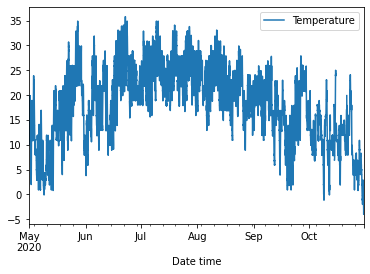

In [9]:
weather.plot(y='Temperature')

In [10]:
weather['Dew Point'][:].max()

22.1

In [11]:
from scipy.interpolate import interp1d
t_data = np.arange(0,weather.shape[0]*15*60,15*60)
weather['Wind Speed'] = weather['Wind Speed'].interpolate('cubic')
weather['Temperature'] = weather['Temperature'].interpolate('cubic')
weather['Solar Radiation'] = weather['Solar Radiation'].interpolate('cubic')
weather['Cloud Cover'] = weather['Cloud Cover'].interpolate('cubic')
weather['Dew Point'] = weather['Dew Point'].interpolate('cubic')
U_atm = np.abs(weather['Wind Speed'][:].to_numpy()/3.6)
T_atm = weather['Temperature'][:].to_numpy()
q_sun = weather['Solar Radiation'][:].to_numpy()
# CC = weather['Cloud Cover'][:].to_numpy()
cc = weather['Cloud Cover'][:].to_numpy()/100
cctmp = np.minimum(cc, np.ones_like(cc))
cc = np.maximum(cctmp,np.zeros_like(cc))
T_dp = weather['Dew Point'][:].to_numpy()
f_U_atm = interp1d(t_data,U_atm,kind='cubic')
f_T_atm = interp1d(t_data,T_atm,kind='cubic')
f_q_sun = interp1d(t_data,q_sun,kind='cubic')
f_CC = interp1d(t_data,cc,kind='cubic')
f_T_dp = interp1d(t_data,T_dp,kind='cubic')


In [12]:
import scipy.constants as csts
from scipy.integrate import solve_ivp
import thermodynamics as thermo
import HT_external_convection as extconv
import HT_natural_convection as natconv
rho = 20.
C_p = 2500.
k = 0.05
H = 0.05
alpha_s = 0.5
eps_sky = 1.
Lplate = 1.
A = Lplate**2
T_s_lower = 0.

def f(t,T):
    global Lplate,k,H,eps,f_U_atm,f_T_atm,f_q_sun,rho,C_p,alpha_s,f_CC,f_T_dp
    # film temperature between ambient and upper surface
    Tinf = f_T_atm(t)
    Uinf = np.max([f_U_atm(t),0.])
    q_irr = alpha_s*f_q_sun(t)
    T_f = (T[0]+Tinf)/2
    air_f = thermo.Fluid('air',T_f,"C")
    # sky radiation
    Tdp = f_T_dp(t)
    eps_clear = 0.711 + 0.56*(Tdp/100.) + 0.73*(Tdp/100.)**2
    cc = f_CC(t)/100.
    Ca = 1. + 0.02224*cc + 0.0035*cc**2 + 0.00028*cc**3
    Tsky = (Ca*eps_clear)**0.25*thermo.C2K(Tinf)
    qsky = eps_sky*csts.sigma*(Tsky**4 - thermo.C2K(T[0])**4)
    
    Re = np.abs(Uinf)*Lplate/air_f.nu
    Gr = natconv.Gr(beta=air_f.beta,DT=np.abs(T-T_f),D=Lplate,nu=air_f.nu)
    Ra = natconv.Ra(beta=air_f.beta,DT=np.abs(T-T_f),D=Lplate,nu=air_f.nu,alpha=air_f.alpha)
# Debug
#     Ri = Gr/Re**2
#     if i>1050:
#         print(i,"Re=%1.2e, Ra=%1.2e, Ri=%1.2e"%(Re,Ra,Ri))
#         print(i,Uinf,air_f.nu,air_f.alpha)
    # Forced convection flux
    if Re >0 and (Re <= 5e5):
        airflow = extconv.FlatPlate('laminar','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=Lplate,xi=0,Re_xc= 5e5)
        airflow.average(Lplate)
        hconv_f = airflow.Nu_ave*air_f.k/Lplate
    elif Re > 5e5:
        airflow = extconv.FlatPlate('mixed','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=Lplate,xi=0,Re_xc= 5e5)
        airflow.average(Lplate)
        hconv_f = airflow.Nu_ave*air_f.k/Lplate
    else:
        hconv_f = 0
    #Natural convection flux
    if Ra > 1e4:
        if T[0] >= Tinf:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','hot')
        else:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','cold')
        hconv_n = airflow.Nu*air_f.k/Lplate
    else:
        hconv_n = 0
    #Total convection flux (here not a function of Ri)
    h = hconv_n + hconv_f
    
    qpp_conv = h*(Tinf - T[0])
    #Conduction flux
    qpp_cond = k*(T[0] - T_s_lower)/H
#     if i > 1050:
#         print(i,hconv_n, hconv_f)
#         print(i,"DT",Tinf - T,T - T_s_lower)
#         print(i,"qpp",qpp_conv,qpp_cond)    
    
#     print(q_irr,qpp_conv,qsky)
#     print(T_f,Tsky,cc,Ca,eps_clear,csts.sigma)
    return (q_irr+qpp_conv+qsky - qpp_cond)/(rho*C_p)

# Simulation

# f(8000,[15])
# sol = solve_ivp(f,[0,t_data[-1]],[0.],t_eval=t_data,max_step=60.)
tmax = t_data[-1]
mask = np.where(t_data <= tmax)
sol = solve_ivp(f,[0,tmax],[10.],method='LSODA',t_eval=t_data[mask],max_step=5*60.)

# sol = solve_ivp(f,[0,100000],[0.])

In [13]:
weather['Ts upper'] = sol.y[0]
weather['q out'] = k*A*sol.y[0]/H
weather['q irr'] = alpha_s*weather['Solar Radiation'][:]*A

<AxesSubplot:xlabel='Date time'>

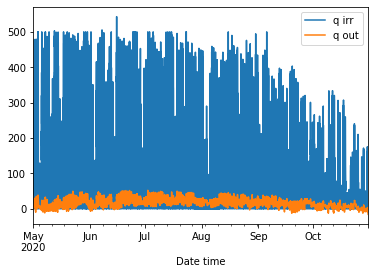

In [13]:
ax0 = weather.plot(y='q irr')
weather.plot(y='q out',ax = ax0)


In [24]:
weather['q out'].sum()*15*60*1e-6

177.1707775207788

In [ ]:
# weather['Temperature'].interpolate(method='spline')
np.argwhere(np.isnan(weather['Temperature'][:].to_numpy()))

<AxesSubplot:xlabel='Date time'>

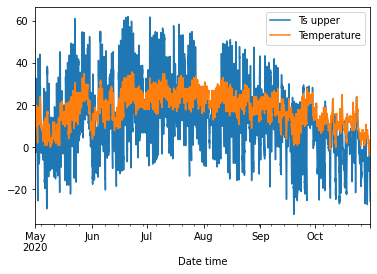

In [25]:

ax0 = weather.plot(y='Ts upper')
weather.plot(y='Temperature',ax = ax0)

In [ ]:
weather_1H = weather.resample("1H").mean()
weather_1H['Energy slab'] = k*A/H*weather_1H['Ts upper']

In [ ]:
ax0 = weather_1H.plot(y='Ts upper')
weather_1H.plot(y='Temperature',ax = ax0)

In [ ]:
weather_1H.plot(y='Energy slab')

In [ ]:
weather_1H['Energy slab'].sum()